<a href="https://colab.research.google.com/github/shishir-joshi/notebooks/blob/master/Image_Classification_Caltech101_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Training a CNN on the Caltech101 dataset

[http://www.vision.caltech.edu/Image_Datasets/Caltech101/]

There are 101 categories with 300x200 px per image

In [1]:
!pip install tensorflow-gpu==2.0.0-alpha0
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tarfile
import random
from pathlib import Path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dense,Flatten,Conv2D,MaxPool2D,BatchNormalization
from tensorflow.keras.optimizers import Adamax,Nadam,Adam,Adagrad,RMSprop
from tensorflow.keras.losses import mean_squared_logarithmic_error,categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from random import shuffle
#tf.enable_eager_execution()

     |████████████████████████████████| 332.1MB 54kB/s 
     |████████████████████████████████| 3.0MB 37.3MB/s 
     |████████████████████████████████| 419kB 44.0MB/s 


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

Structure of the code:
    1. Download the dataset
    2. Define parameters: batch_size,epochs,num_classes
    3. Make Util Methods: 
            Pre-process, Get Labels from prediction, 
            shuffle, Make labels as categorical
    4. Define Dataset Preparation Methods:  
            return (x_tr,y_tr),(x_te,y_te) shuffled, batched tuples as numpy/tf.data
    6. %Make Learning rate scheduler
    7. Define Model:
            i. Transfer Learning on MobileNetv2 
            ii. My Model
    8. Train and Evaluate


In [2]:
!wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz

to_extract = tarfile.open('101_ObjectCategories.tar.gz','r:gz')
to_extract.extractall()

--2019-12-05 13:29:08--  http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131740031 (126M) [application/x-tar]
Saving to: ‘101_ObjectCategories.tar.gz’

101_ObjectCategorie 100%[===================>] 125.64M  6.52MB/s    in 22s     

2019-12-05 13:29:31 (5.60 MB/s) - ‘101_ObjectCategories.tar.gz’ saved [131740031/131740031]



####Preparing tf.data dataset from the images present in the tar.gz

In [0]:
# Util functions


def shuffle_list(*ls):
  l = list(zip(*ls))
  shuffle(l)
  return zip(*l)

def preprocess(path):
  img_raw = tf.io.read_file(path)
  img_decoded = tf.image.decode_jpeg(img_raw,channels=3)
  img_decoded = tf.image.resize(img_decoded,[128,128])
  img_decoded /= 255
  return img_decoded

def preprocess2(path):
  img_raw = tf.io.read_file(path)
  img_decoded = tf.image.decode_jpeg(img_raw,channels=3)
#   img_decoded = tf.image.resize(img_decoded,[128,128])
#   img_decoded /= 255
  return img_decoded

def get_label_from_prediction(top_pred):
  return list(class_to_index.keys())[list(class_to_index.values()).index(top_pred)]

# Parameters
BATCH_SIZE=100
categories_used = 101
# Takes image folder path and returns train and test datasets
def make_dataset(folder_path, train_split=0.8, categories_used = 101, batch_size=100):
  paths = Path(folder_path)
  class_paths = [x for x in paths.iterdir() if x.is_dir()]
  classes = [x.stem for x in class_paths[:categories_used]]
  class_to_index = dict((v,k) for k,v in enumerate(classes[:categories_used]))
  file_paths = [list(x.glob('*.jpg')) for x in class_paths[:categories_used]]
  print("Number of file paths:{0}".format(len(file_paths)))
  
  # "Unrolling" the file_paths 
  label_paths = list()
  for path in file_paths:
    for pt in path:
      label_paths.append(pt)
  print(len(label_paths))
  labels = [class_to_index[l.parent.name] for l in label_paths]
  
  # shuffling 
  shuff_paths, shuff_labels = shuffle_list(label_paths,labels)
  shuff_paths = [str(p) for p in shuff_paths]
  shuff_labels = [p for p in shuff_labels]
  
  # making labels categorical
  shuff_labels = to_categorical(shuff_labels,num_classes=categories_used)
  
  # train test split
  X_train, X_test, y_train, y_test = train_test_split(shuff_paths,
                                                      shuff_labels,
                                                      test_size=1-train_split)
  
  # make the datasets
  path_ds_train = tf.data.Dataset.from_tensor_slices(X_train)
  path_ds_test = tf.data.Dataset.from_tensor_slices(X_test)
  image_ds_train = path_ds_train.map(preprocess,num_parallel_calls=4)
  image_ds_test = path_ds_test.map(preprocess,num_parallel_calls=4)
  label_ds_train = tf.data.Dataset.from_tensor_slices(tf.cast(y_train, tf.int64))
  label_ds_test = tf.data.Dataset.from_tensor_slices(tf.cast(y_test, tf.int64))
  train_ds = tf.data.Dataset.zip((image_ds_train,label_ds_train))
  test_ds = tf.data.Dataset.zip((image_ds_test,label_ds_test))
  
  # Batch
  train_ds = train_ds.batch(batch_size)
  test_ds = test_ds.batch(batch_size)

  # Prefetch
  train_ds = train_ds.prefetch(buffer_size = 1000)
  test_ds = test_ds.prefetch(buffer_size = 1000)
  return (train_ds,test_ds,shuff_paths,class_to_index,X_test,y_test)
    
# datast = make_dataset('101_ObjectCategories/') 


# Takes image file path and feeds it to model
def input_pipe(image_path, model=None, plot=False):
  image = preprocess(image_path)
  if(plot==False):
    return np.reshape(image,(-1,128,128,3))
  else:
    return image


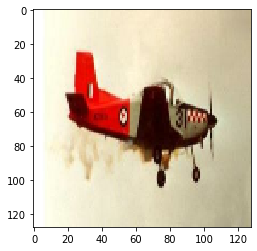

In [4]:
plt.imshow(input_pipe('101_ObjectCategories/airplanes/image_0002.jpg',plot=True))

In [5]:
# DATASET
train_ds,test_ds,shuff_paths,class_to_index,X_test,y_test = make_dataset('101_ObjectCategories/')

Number of file paths:101
9091


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


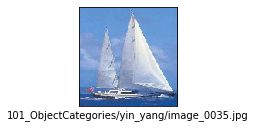

In [6]:
n=1
for record,_ in train_ds.take(4):
  label = record[0]
  image = record[1]
  plt.subplot(2,2,++n)
  plt.imshow(image.numpy()[:, :, :].astype(np.float32))
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(shuff_paths[n])

###_Transfer Learning MobileNetv2_

In [7]:
IMGSIZE = (128,128,3)
mob_net_model = tf.keras.applications.MobileNetV2(input_shape=IMGSIZE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 1s 0us/step


In [8]:
mob_net_model.input.shape

TensorShape([None, 128, 128, 3])

In [0]:
mob_net_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(1000, activation='sigmoid')
soft_layer = tf.keras.layers.Dense(101, activation='softmax')

In [10]:
TL_model = tf.keras.Sequential([
              mob_net_model,
              global_average_layer,
              dense_layer,
              soft_layer
        ])

# Configure a model for categorical classification.
TL_model.compile(optimizer=tf.keras.optimizers.Adam(0.1),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

TL_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1000)              1281000   
_________________________________________________________________
dense_1 (Dense)              (None, 101)               101101    
Total params: 3,640,085
Trainable params: 1,382,101
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
# define the checkpoints
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, mode='min')
callbacks_list = [checkpoint]

In [0]:
TL_model.fit(train_ds,
          validation_data = test_ds,
          epochs=200,
          #steps_per_epoch=100,
          callbacks = callbacks_list)

###_My Model_

        v0.1:
          CONV 50
          MAXPOOL
          CONV 20
          MAXPOOL
          CONV 10
          MAXPOOL
          FC 100 
          FC 50
          FC num_classes
          

In [0]:
my_model = keras.Sequential([
    keras.layers.Conv2D(50,kernel_size=3,strides=1,activation='relu'),
    keras.layers.MaxPool2D(pool_size=2,strides=2,padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(20,kernel_size=3,activation='relu'),
    keras.layers.MaxPool2D(pool_size=2,strides=2,padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(10,kernel_size=3,activation='relu'),
    keras.layers.MaxPool2D(pool_size=2,strides=2,padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(100,activation='tanh'),
    keras.layers.Dense(25,activation='tanh'),
    keras.layers.Dense(10,activation='tanh'),    
    keras.layers.Dense(categories_used,activation='sigmoid')
])

# Configure a model for categorical classification.
my_model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [0]:
my_model.summary()

In [0]:
# define the checkpointA
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [0]:
my_model.fit(train_ds,
          validation_data = test_ds,
          epochs=50,
          #steps_per_epoch=10000,

          callbacks = callbacks_list)

Epoch 1/50
72/73 [============================>.] - ETA: 0s - loss: 4.4656 - categorical_accuracy: 0.1432
Epoch 00001: loss improved from inf to 4.46495, saving model to weights-improvement-01-4.4650.hdf5
73/73 [==============================] - 18s 240ms/step - loss: 4.4647 - categorical_accuracy: 0.1451 - val_loss: 4.5296 - val_categorical_accuracy: 0.0995
Epoch 2/50
72/73 [============================>.] - ETA: 0s - loss: 4.3384 - categorical_accuracy: 0.3193
Epoch 00002: loss improved from 4.46495 to 4.33779, saving model to weights-improvement-02-4.3378.hdf5
73/73 [==============================] - 10s 142ms/step - loss: 4.3376 - categorical_accuracy: 0.3193 - val_loss: 4.4432 - val_categorical_accuracy: 0.0962
Epoch 3/50
72/73 [============================>.] - ETA: 0s - loss: 4.2335 - categorical_accuracy: 0.3304
Epoch 00003: loss improved from 4.33779 to 4.23285, saving model to weights-improvement-03-4.2329.hdf5
73/73 [==============================] - 10s 141ms/step - loss: 4

###_Evaluating Model Performance_

In [0]:
# load the network weights weights-improvement-37-0.0005.hdf5
filename = !ls -Art | tail -n 1
print(filename[0])
my_model.load_weights(filename[0])
my_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['categorical_accuracy'])

In [0]:
test_eval = my_model.evaluate(test_ds,callbacks=callbacks_list)
print(" Final Loss: ",test_eval[0])
print(" Final Accuracy: {}%".format(test_eval[1]*100))

In [0]:
#An example image
# im_path = X_test[random.randint(0,len(X_test))]
im_path = '/content/101_ObjectCategories/airplanes/image_0002.jpg'
plt.imshow(preprocess2(im_path))

img=input_pipe(im_path)
prediction = np.argmax(my_model.predict(img))



print("Predicted Label: ",get_label_from_prediction(prediction))
print("Actual Label: ",Path(im_path).parent.stem)